In [20]:
# imports

from solvation_analysis.rdf_parser import plot_interpolation_fit
from pathlib import Path
import numpy as np

# data directories
easy_rdf_dir = Path("solvation_analysis/tests/data/rdf_vs_li_easy")

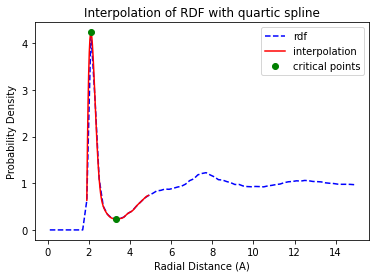

In [23]:
# example rdf plot

easy_rdf_bins = np.load(easy_rdf_dir / "rdf_fec_O_bins.npy")
easy_rdf_data = np.load(easy_rdf_dir / "rdf_fec_O_data.npy")
plot_interpolation_fit(easy_rdf_bins, easy_rdf_data)